# 数据集处理

In [1]:
import os

# 文件夹路径
dir_data = "data"

# 列出文件夹下的所有文件
files_data_train_all = [os.path.join(dir_data, "train", file) for file in os.listdir(os.path.join(dir_data, "train"))]
files_data_validation_all = [os.path.join(dir_data, "validation", file) for file in os.listdir(os.path.join(dir_data, "validation"))]
files_data_test_all = [os.path.join(dir_data, "test", file) for file in os.listdir(os.path.join(dir_data, "test"))]

# 分别筛选出.txt和.png文件
files_data_train_txt = [file for file in files_data_train_all if file.endswith('.txt')]
files_data_train_png = [file for file in files_data_train_all if file.endswith('.png')]

files_data_validation_txt = [file for file in files_data_validation_all if file.endswith('.txt')]
files_data_validation_png = [file for file in files_data_validation_all if file.endswith('.png')]

files_data_test_txt = [file for file in files_data_test_all if file.endswith('.txt')]
files_data_test_png = [file for file in files_data_test_all if file.endswith('.png')]


# 输出文件路径数组
print("TXT文件路径：", files_data_train_txt[:5])
print("PNG文件路径：", files_data_train_png[:5])


TXT文件路径： ['data\\train\\center_0.txt', 'data\\train\\center_1.txt', 'data\\train\\center_10.txt', 'data\\train\\center_100.txt', 'data\\train\\center_1000.txt']
PNG文件路径： ['data\\train\\image_0.png', 'data\\train\\image_1.png', 'data\\train\\image_10.png', 'data\\train\\image_100.png', 'data\\train\\image_1000.png']


In [2]:
def pair_files(txt_files, png_files):
    paired_files = []
    # 基于文件名（无扩展名）进行匹配
    for txt_file,png_file in zip(txt_files,png_files):
        paired_files.append((txt_file, png_file))
    return paired_files

# 创建训练、验证和测试数据集
dataset_train = pair_files(files_data_train_txt, files_data_train_png)
dataset_validation = pair_files(files_data_validation_txt, files_data_validation_png)
dataset_test = pair_files(files_data_test_txt, files_data_test_png)

# 输出数据集示例
print("训练数据集示例：", dataset_train[:3])
print("验证数据集示例：", dataset_validation[:3])
print("测试数据集示例：", dataset_test[:3])


训练数据集示例： [('data\\train\\center_0.txt', 'data\\train\\image_0.png'), ('data\\train\\center_1.txt', 'data\\train\\image_1.png'), ('data\\train\\center_10.txt', 'data\\train\\image_10.png')]
验证数据集示例： [('data\\validation\\center_0.txt', 'data\\validation\\image_0.png'), ('data\\validation\\center_1.txt', 'data\\validation\\image_1.png'), ('data\\validation\\center_10.txt', 'data\\validation\\image_10.png')]
测试数据集示例： [('data\\test\\center_0.txt', 'data\\test\\image_0.png'), ('data\\test\\center_1.txt', 'data\\test\\image_1.png'), ('data\\test\\center_10.txt', 'data\\test\\image_10.png')]


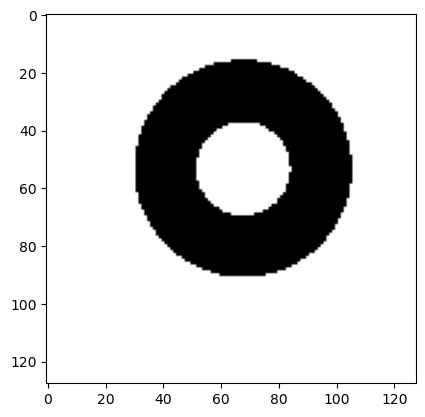

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
torch.Size([1, 1, 224, 224])
tensor(-1.)


In [3]:
import torch
import torchvision.transforms as transforms
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

# Load your single-channel image
image_path = files_data_train_png[0]
image = Image.open(image_path).convert('L')  # Convert image to grayscale

# Display the image
plt.imshow(image, cmap='gray')  # Use grayscale color map
plt.show()

# Preprocess the image  定义数据转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ResNet50 input dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for single-channel
])

image = transform(image).unsqueeze(0)  # Add batch dimension

print(image)
print(image.shape)
print(image[0, 0, 80, 80])


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

def read_dataset(dataset_files):
    dataset = []
    for txt_file, png_file in tqdm(dataset_files, desc="Processing dataset", total=len(dataset_files)):
        image = Image.open(png_file).convert('L')  # 转换为灰度图像
        image = transform(image)
        # 读取txt文件，每个txt包含"x,y"格式的数据
        with open(txt_file, 'r') as f:
            line = f.readline()
            x, y = map(float, line.split(','))  # 解析x和y
        dataset.append((image, torch.tensor([x, y])))  # 将图像和标签添加到数据集中
    return dataset

# 创建训练、验证和测试数据集
dataset_train = read_dataset(dataset_train)
dataset_validation = read_dataset(dataset_validation)
dataset_test = read_dataset(dataset_test)

# 创建 DataLoader 加载训练数据集
batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_validation, batch_size=batch_size)
test_loader = DataLoader(dataset_test, batch_size=batch_size)

Processing dataset: 100%|█████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 819.39it/s]


In [5]:
images, labels = next(iter(train_loader))
print("图像形状:", images.shape)  # 应为(batch_size, channels, height, width)
print("标签形状:", labels.shape)  # 应为(batch_size, 2)，每个样本有两个坐标值


图像形状: torch.Size([32, 1, 224, 224])
标签形状: torch.Size([32, 2])


# 模型

In [6]:
from torch import nn
from torchvision.models import resnet50

# Modify ResNet50
class ResNet50Regression(nn.Module):
    def __init__(self):
        super(ResNet50Regression, self).__init__()
        resnet = resnet50(pretrained=True)
        
        # Replace the first convolutional layer to accept single-channel input
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            *list(resnet.children())[1:-1]
        )
        
        # Replace the last fully connected layer to output a single value
        self.regressor = nn.Linear(resnet.fc.in_features, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x

In [7]:
import torch
from tqdm import tqdm

def evaluate(model, test_loader):
    model.eval()  # 将模型设置为评估模式
    total_loss = 0
    with torch.no_grad():  # 禁用梯度计算
        test_loader_tqdm = tqdm(test_loader, desc=f'Evaluate')
        for images, targets in test_loader_tqdm:  # 使用测试数据集
            images = images.to(device)
            targets = targets.to(device)

            # 执行前向传播
            outputs = model(images)

            # 计算损失
            loss = criterion(outputs, targets[:, 0].unsqueeze(1))
            total_loss += loss.item()

    # 计算平均损失并返回
    return total_loss / len(test_loader)


# Define the device based on the availability of CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'use {device}')

# Initialize the model and move it to the chosen device
model = ResNet50Regression().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

D:\Env\Anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Env\Anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


use cuda


In [10]:
import os
import shutil

# 定义文件夹路径
folder_path = 'save'

# 检查文件夹是否存在
if os.path.exists(folder_path):
    # 清空文件夹
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
else:
    # 如果文件夹不存在，则创建它
    os.makedirs(folder_path)

In [11]:
# Training process
num_epochs = 500  # Define the number of epochs for training
train_losses = []
val_losses = []
min_val_lost = 99999999

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Wrap the train_loader with tqdm for a progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for images, targets in train_loader_tqdm:
        # Move images and targets to the chosen device
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Zero the gradients
        
        # Perform the forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, targets[:,0].unsqueeze(1))
        total_loss += loss.item()
        
        # Perform backpropagation
        loss.backward()
        optimizer.step()

    # Print average loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = evaluate(model, validation_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}')

    if min_val_lost > avg_val_loss:
        min_val_lost = avg_val_loss
        model_name = f'{folder_path}\\resnet50_regression_{min_val_lost:.4f}.pth'  # 使用损失值作为文件名的一部分
        torch.save(model.state_dict(), model_name)
    
# 获取测试集上的损失值
test_loss = evaluate(model, test_loader)
print(f'Test loss: {test_loss}')

# 保存模型
model_name = f'resnet50_regression_{test_loss:.4f}.pth'  # 使用损失值作为文件名的一部分
torch.save(model.state_dict(), model_name)

Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.00it/s]


Epoch 1/500, Train loss: 4.6009, Validation loss: 1.5672


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.89it/s]


Epoch 2/500, Train loss: 6.0720, Validation loss: 2.3136


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.41it/s]


Epoch 3/500, Train loss: 2.8119, Validation loss: 1.9290


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.59it/s]


Epoch 4/500, Train loss: 2.3180, Validation loss: 1.9413


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.11it/s]


Epoch 5/500, Train loss: 0.8541, Validation loss: 0.2212


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.09it/s]


Epoch 6/500, Train loss: 0.8500, Validation loss: 1.6709


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.16it/s]


Epoch 7/500, Train loss: 1.0846, Validation loss: 0.3264


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.20it/s]


Epoch 8/500, Train loss: 0.7605, Validation loss: 0.4766


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.11it/s]


Epoch 9/500, Train loss: 0.6621, Validation loss: 1.5580


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.25it/s]


Epoch 10/500, Train loss: 0.8548, Validation loss: 0.8076


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.31it/s]


Epoch 11/500, Train loss: 0.7238, Validation loss: 1.6666


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.38it/s]


Epoch 12/500, Train loss: 8.1967, Validation loss: 2.3503


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.35it/s]


Epoch 13/500, Train loss: 2.5939, Validation loss: 0.8141


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.38it/s]


Epoch 14/500, Train loss: 1.1001, Validation loss: 1.5669


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.55it/s]


Epoch 15/500, Train loss: 1.1376, Validation loss: 1.3901


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00,  9.65it/s]


Epoch 16/500, Train loss: 0.7102, Validation loss: 0.7113


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.47it/s]


Epoch 17/500, Train loss: 1.8360, Validation loss: 0.7077


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00,  9.72it/s]


Epoch 18/500, Train loss: 6.3003, Validation loss: 82.2777


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.19it/s]


Epoch 19/500, Train loss: 3.0727, Validation loss: 0.8960


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.33it/s]


Epoch 20/500, Train loss: 1.3062, Validation loss: 0.6577


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.68it/s]


Epoch 21/500, Train loss: 0.6403, Validation loss: 0.7091


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.69it/s]


Epoch 22/500, Train loss: 0.7082, Validation loss: 0.8300


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.97it/s]


Epoch 23/500, Train loss: 0.5641, Validation loss: 0.4133


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.77it/s]


Epoch 24/500, Train loss: 0.6778, Validation loss: 0.1595


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.02it/s]


Epoch 25/500, Train loss: 0.3582, Validation loss: 0.4736


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.80it/s]


Epoch 26/500, Train loss: 0.4333, Validation loss: 0.5824


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.74it/s]


Epoch 27/500, Train loss: 0.4135, Validation loss: 1.6252


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.84it/s]


Epoch 28/500, Train loss: 0.6903, Validation loss: 1.0896


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.90it/s]


Epoch 29/500, Train loss: 0.3725, Validation loss: 0.0907


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.95it/s]


Epoch 30/500, Train loss: 0.3942, Validation loss: 1.0093


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.03it/s]


Epoch 31/500, Train loss: 5.9058, Validation loss: 0.8479


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.89it/s]


Epoch 32/500, Train loss: 0.6679, Validation loss: 0.3847


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.06it/s]


Epoch 33/500, Train loss: 0.3519, Validation loss: 1.5791


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.09it/s]


Epoch 34/500, Train loss: 0.3995, Validation loss: 0.3422


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.80it/s]


Epoch 35/500, Train loss: 0.5276, Validation loss: 0.5120


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.07it/s]


Epoch 36/500, Train loss: 0.3913, Validation loss: 0.3641


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.07it/s]


Epoch 37/500, Train loss: 0.1795, Validation loss: 0.1241


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.07it/s]


Epoch 38/500, Train loss: 0.4557, Validation loss: 0.2516


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.09it/s]


Epoch 39/500, Train loss: 0.9266, Validation loss: 0.1316


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.11it/s]


Epoch 40/500, Train loss: 0.2272, Validation loss: 1.3406


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.89it/s]


Epoch 41/500, Train loss: 0.2272, Validation loss: 0.0622


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 42/500, Train loss: 0.3906, Validation loss: 0.8203


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.72it/s]


Epoch 43/500, Train loss: 0.8718, Validation loss: 1.0538


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.69it/s]


Epoch 44/500, Train loss: 0.3542, Validation loss: 0.6394


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.85it/s]


Epoch 45/500, Train loss: 0.1373, Validation loss: 0.1163


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.71it/s]


Epoch 46/500, Train loss: 0.3228, Validation loss: 0.3263


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.23it/s]


Epoch 47/500, Train loss: 0.1725, Validation loss: 0.1081


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.69it/s]


Epoch 48/500, Train loss: 0.3941, Validation loss: 0.2772


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.81it/s]


Epoch 49/500, Train loss: 0.2695, Validation loss: 0.2527


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 50/500, Train loss: 0.1645, Validation loss: 0.2625


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.69it/s]


Epoch 51/500, Train loss: 0.2710, Validation loss: 0.0994


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.88it/s]


Epoch 52/500, Train loss: 0.2378, Validation loss: 0.3045


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.05it/s]


Epoch 53/500, Train loss: 0.2793, Validation loss: 0.4050


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.99it/s]


Epoch 54/500, Train loss: 0.1709, Validation loss: 1.4970


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.86it/s]


Epoch 55/500, Train loss: 0.3597, Validation loss: 0.6367


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.25it/s]


Epoch 56/500, Train loss: 0.1708, Validation loss: 0.0588


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.90it/s]


Epoch 57/500, Train loss: 0.8844, Validation loss: 0.6646


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.72it/s]


Epoch 58/500, Train loss: 0.1581, Validation loss: 0.0483


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.65it/s]


Epoch 59/500, Train loss: 0.1252, Validation loss: 0.2395


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.72it/s]


Epoch 60/500, Train loss: 0.2319, Validation loss: 0.0573


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.80it/s]


Epoch 61/500, Train loss: 0.2789, Validation loss: 0.0884


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 62/500, Train loss: 0.2216, Validation loss: 0.3436


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.82it/s]


Epoch 63/500, Train loss: 0.1971, Validation loss: 0.2762


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.68it/s]


Epoch 64/500, Train loss: 0.1495, Validation loss: 0.2369


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.68it/s]


Epoch 65/500, Train loss: 0.0576, Validation loss: 0.0637


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.74it/s]


Epoch 66/500, Train loss: 0.0848, Validation loss: 0.0472


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.74it/s]


Epoch 67/500, Train loss: 0.1776, Validation loss: 0.0698


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 68/500, Train loss: 0.4318, Validation loss: 1.3404


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.60it/s]


Epoch 69/500, Train loss: 0.6101, Validation loss: 0.4176


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.71it/s]


Epoch 70/500, Train loss: 0.1846, Validation loss: 0.1056


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.59it/s]


Epoch 71/500, Train loss: 0.1140, Validation loss: 0.5302


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.73it/s]


Epoch 72/500, Train loss: 0.0963, Validation loss: 0.1248


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.63it/s]


Epoch 73/500, Train loss: 0.1344, Validation loss: 0.3291


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.66it/s]


Epoch 74/500, Train loss: 0.0990, Validation loss: 0.1200


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 75/500, Train loss: 0.1445, Validation loss: 0.3701


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.84it/s]


Epoch 76/500, Train loss: 0.1675, Validation loss: 0.4878


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.67it/s]


Epoch 77/500, Train loss: 0.1429, Validation loss: 0.2777


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.70it/s]


Epoch 78/500, Train loss: 0.1116, Validation loss: 0.0877


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.61it/s]


Epoch 79/500, Train loss: 0.2148, Validation loss: 0.4774


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.70it/s]


Epoch 80/500, Train loss: 0.3357, Validation loss: 0.0685


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 81/500, Train loss: 0.0703, Validation loss: 0.3860


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.76it/s]


Epoch 82/500, Train loss: 0.1504, Validation loss: 0.1652


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 83/500, Train loss: 0.1600, Validation loss: 0.0617


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.71it/s]


Epoch 84/500, Train loss: 0.6713, Validation loss: 0.6162


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.76it/s]


Epoch 85/500, Train loss: 0.2898, Validation loss: 0.1361


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.66it/s]


Epoch 86/500, Train loss: 0.1055, Validation loss: 0.3596


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.69it/s]


Epoch 87/500, Train loss: 0.0785, Validation loss: 0.0464


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch 88/500, Train loss: 0.1194, Validation loss: 0.1547


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.72it/s]


Epoch 89/500, Train loss: 0.0914, Validation loss: 0.4204


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.84it/s]


Epoch 90/500, Train loss: 0.0836, Validation loss: 0.0802


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 91/500, Train loss: 0.2347, Validation loss: 0.1208


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.76it/s]


Epoch 92/500, Train loss: 0.1342, Validation loss: 0.2134


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.73it/s]


Epoch 93/500, Train loss: 0.1634, Validation loss: 0.0424


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 94/500, Train loss: 0.0622, Validation loss: 0.0351


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.71it/s]


Epoch 95/500, Train loss: 0.1917, Validation loss: 0.0392


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.69it/s]


Epoch 96/500, Train loss: 2.2384, Validation loss: 0.4886


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.77it/s]


Epoch 97/500, Train loss: 0.2322, Validation loss: 0.3217


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.80it/s]


Epoch 98/500, Train loss: 0.2309, Validation loss: 0.1072


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.08it/s]


Epoch 99/500, Train loss: 0.1616, Validation loss: 0.2305


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [01:24<00:00,  1.48it/s]


Epoch 100/500, Train loss: 0.0999, Validation loss: 0.1200


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.79it/s]


Epoch 101/500, Train loss: 0.0548, Validation loss: 0.1049


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.76it/s]


Epoch 102/500, Train loss: 0.0909, Validation loss: 0.2065


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.79it/s]


Epoch 103/500, Train loss: 0.1066, Validation loss: 0.0361


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.66it/s]


Epoch 104/500, Train loss: 0.2040, Validation loss: 0.1266


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.73it/s]


Epoch 105/500, Train loss: 0.0970, Validation loss: 0.0356


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.76it/s]


Epoch 106/500, Train loss: 0.0949, Validation loss: 0.1450


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 107/500, Train loss: 0.0761, Validation loss: 0.0469


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.86it/s]


Epoch 108/500, Train loss: 0.1039, Validation loss: 0.0657


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.80it/s]


Epoch 109/500, Train loss: 0.0868, Validation loss: 0.5118


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.79it/s]


Epoch 110/500, Train loss: 0.2367, Validation loss: 0.1678


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.66it/s]


Epoch 111/500, Train loss: 0.4089, Validation loss: 3.9513


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.73it/s]


Epoch 112/500, Train loss: 0.3143, Validation loss: 0.1408


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 113/500, Train loss: 0.0979, Validation loss: 0.8202


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 114/500, Train loss: 0.0733, Validation loss: 0.0659


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.24it/s]


Epoch 115/500, Train loss: 0.0588, Validation loss: 0.0910


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.91it/s]


Epoch 116/500, Train loss: 0.2072, Validation loss: 0.0433


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.72it/s]


Epoch 117/500, Train loss: 0.0655, Validation loss: 0.1466


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.85it/s]


Epoch 118/500, Train loss: 0.0711, Validation loss: 0.4034


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.62it/s]


Epoch 119/500, Train loss: 0.0663, Validation loss: 0.2055


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [01:00<00:00,  2.07it/s]


Epoch 120/500, Train loss: 0.0999, Validation loss: 0.1043


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.71it/s]


Epoch 121/500, Train loss: 0.1799, Validation loss: 0.7054


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.73it/s]


Epoch 122/500, Train loss: 0.1344, Validation loss: 0.0405


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.70it/s]


Epoch 123/500, Train loss: 0.0919, Validation loss: 0.1720


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00,  9.87it/s]


Epoch 124/500, Train loss: 0.1021, Validation loss: 0.2229


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.68it/s]


Epoch 125/500, Train loss: 0.0493, Validation loss: 0.0477


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Epoch 126/500, Train loss: 0.1227, Validation loss: 0.0478


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.77it/s]


Epoch 127/500, Train loss: 0.1446, Validation loss: 0.0706


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 128/500, Train loss: 0.2158, Validation loss: 0.0333


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.76it/s]


Epoch 129/500, Train loss: 0.0652, Validation loss: 0.0328


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.74it/s]


Epoch 130/500, Train loss: 0.0778, Validation loss: 0.4618


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.84it/s]


Epoch 131/500, Train loss: 0.0702, Validation loss: 0.1630


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch 132/500, Train loss: 0.2690, Validation loss: 0.8657


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.08it/s]


Epoch 133/500, Train loss: 0.1248, Validation loss: 0.2372


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.78it/s]


Epoch 134/500, Train loss: 0.0706, Validation loss: 0.1489


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.59it/s]


Epoch 135/500, Train loss: 0.0693, Validation loss: 0.0854


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.65it/s]


Epoch 136/500, Train loss: 0.2711, Validation loss: 0.1022


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.81it/s]


Epoch 137/500, Train loss: 0.1229, Validation loss: 0.1292


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.72it/s]


Epoch 138/500, Train loss: 0.1301, Validation loss: 0.1937


Evaluate: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00,  9.65it/s]


Epoch 139/500, Train loss: 0.1122, Validation loss: 0.2120


Epoch 140/500:  76%|█████████████████████████████████████████████████▏               | 284/375 [03:04<00:59,  1.54it/s]


KeyboardInterrupt: 

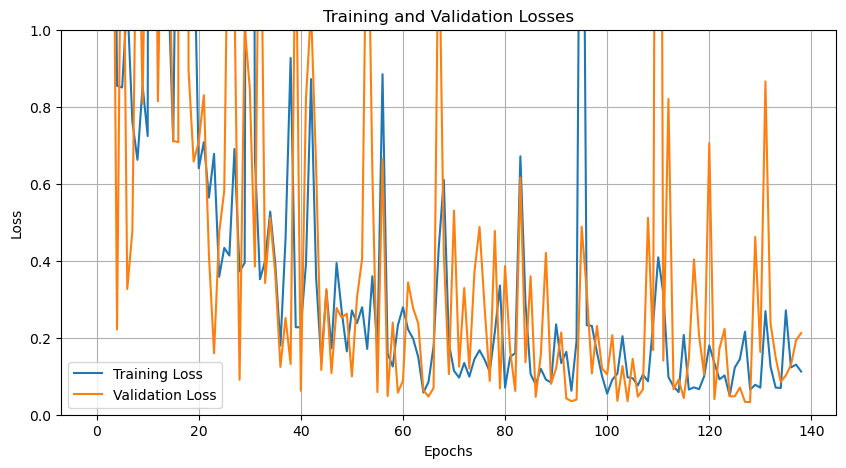

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 设置 y 轴的范围，例如从 0 到 1
plt.ylim(0, 1)
plt.show()


# 读取训练的参数


In [ ]:
# Initialize the model
model_load = ResNet50Regression().to(device)
model_name = 'resnet50_regression_0.0310.pth'
model_load.load_state_dict(torch.load(model_name))

In [ ]:
# 获取测试集上的损失值
test_loss = evaluate(model_load, test_loader)
print(f'Test loss: {test_loss}')

In [ ]:
import os

# 文件夹路径
dir_data = "data\\processed"
dir_temp = "data"

# 列出文件夹下的文件路径
dir_data = [os.path.join(dir_data, file) for file in os.listdir(dir_data)]

# 输出文件路径数组
print("文件夹下的文件路径：", dir_data[:3])


In [ ]:
image = Image.open(dir_data[0]).convert('L')  # Convert image to grayscale

# Display the image
plt.imshow(image, cmap='gray')  # Use grayscale color map
plt.show()

# Preprocess the image  定义数据转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ResNet50 input dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize for single-channel
    transforms.Lambda(lambda x: x.transpose(1, 2)) # 转置!!!用于测试y方向
])

image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

print(image)
print(image.shape)
print(image[0, 0, 80, 80])

model_load.eval()  # 将模型设置为评估模式
with torch.no_grad():  # 禁用梯度计算
    outputs = model_load(image)
    print(outputs)


In [ ]:
outputs = []

model_load.eval()  # 将模型设置为评估模式
with torch.no_grad():  # 禁用梯度计算
    for img_dir in tqdm(dir_data,desc = '识别'):
        #读取图片为tensor.to(device)
        image = Image.open(img_dir).convert('L')
        image = transform(image).unsqueeze(0).to(device)
        output = model_load(image)
        outputs.append(output)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming outputs is a list of scalar values (e.g., model predictions, scores)
# If outputs are tensors, you may need to extract the values first

# Convert outputs to a list of numbers if they are tensors
output_values = [output.item() for output in outputs]

# Plotting the line graph
plt.figure(figsize=(8, 5))
plt.plot(output_values, label='Output Values', marker='o')
plt.xlabel('Image Index')
plt.ylabel('Output Value')
plt.title('Output Values from Model')
plt.legend()
plt.grid(True)
plt.show()

# Convert output_values to a DataFrame
df = pd.DataFrame({'Output Values': output_values})

# Specify the file path where you want to save the Excel file
excel_file_path = 'output_values.xlsx'

# Save the DataFrame to Excel
df.to_excel(excel_file_path, index=False)

print(f'Output values saved to {excel_file_path}')


In [ ]:
import cv2
import numpy as np
import pandas as pd

# 加载视频文件
video_path = 'data\\振动视频1.avi'
cap = cv2.VideoCapture(video_path)

if cap.isOpened():
    # 获取视频的帧率
    fps = cap.get(cv2.CAP_PROP_FPS)
    # 计算每帧的时间间隔
    frame_interval = 1 / fps
    print("帧率（FPS）:", fps)
    print("每帧时间间隔（秒）:", frame_interval)
else:
    print("无法打开视频文件。")

# 释放视频文件
cap.release()

# 假设 output_values 是一个numpy数组，frame_interval 是采样间隔
# output_values = np.array([...])  # 这里填入你的数据
# frame_interval = ...  # 每帧时间间隔

# 执行傅立叶变换
fft_values = np.fft.fft(output_values)

# 计算频率轴
n = len(output_values)  # 数据点的数量
frequencies = np.fft.fftfreq(n, d=frame_interval)

# 计算幅度
magnitude = np.abs(fft_values)

# 因为FFT输出包含负频率，我们通常只关心正频率部分
positive_frequencies = frequencies[:n // 2]
positive_magnitude = magnitude[:n // 2]

# 创建DataFrame
data = {'频率 (Hz)': positive_frequencies, '幅度': positive_magnitude}
df = pd.DataFrame(data)

# 保存为CSV文件
csv_filename = 'Frequency_Magnitude_Data.csv'
df.to_csv(csv_filename, index=False)

print(f"数据已保存到CSV文件：{csv_filename}")

